In [2]:
import sys
sys.path.append('/nfslocal/data1/xinsheng/code/release/RobPitch')

import librosa
import torch
import numpy as np
from robpitch import RobPitch
from utils.audio import load_audio
import matplotlib.pyplot as plt


In [9]:
def draw_spec_pitch(spectrogram, pitch_track):
    sr = 16000
    # Plotting both the spectrogram and the pitch track on the same axes
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='log', hop_length=int(0.01 * sr), cmap='coolwarm', alpha=0.5)
    plt.colorbar(format='%+2.0f dB', label='Decibel Level')

    # Pitch track over spectrogram
    times = librosa.frames_to_time(range(len(pitch_track)), sr=sr, hop_length=int(0.01 * sr))
    plt.plot(times, pitch_track, color='red', linewidth=2, label='Pitch Track')
    plt.title('Spectrogram with Pitch Track Overlay')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.legend(loc='upper right')

    plt.show()

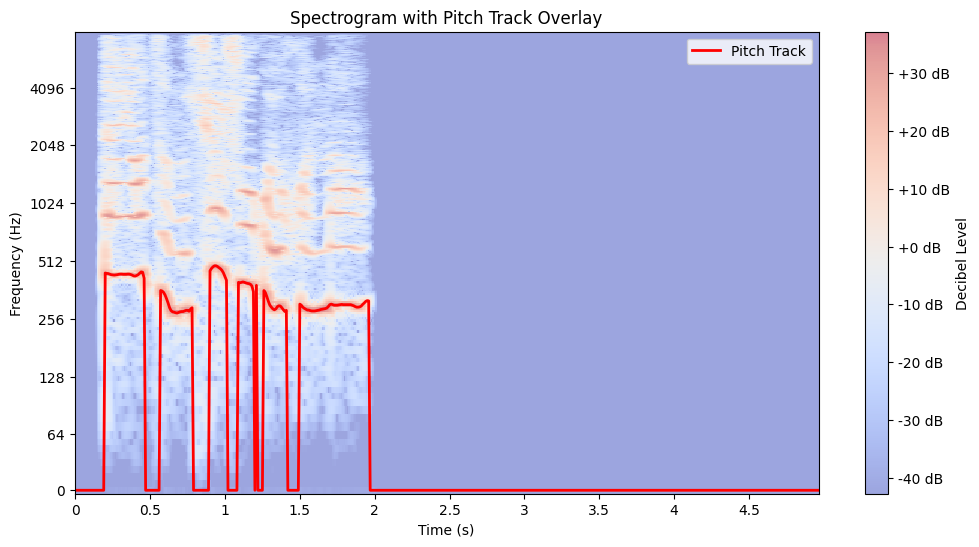

In [10]:
robpitch = RobPitch()
device = torch.device("cuda:6")
model = robpitch.load_from_checkpoint(
    config_path="../config.yaml",
    ckpt_path="../model.bin",
    device=device,
)
# Load and process the audio
wav = load_audio(
    "demo.wav",
        sampling_rate=16000,
        volume_normalize=True,
    )

# Compute the short-time Fourier transform (STFT) for the spectrogram
hop_length = int(0.01 * 16000)  # 10 ms hop length

stft = librosa.stft(wav, hop_length=hop_length)
spectrogram = librosa.amplitude_to_db(np.abs(stft))

wav = torch.from_numpy(wav).unsqueeze(0).float().to(device)
outputs = model(wav)

pitch_track = outputs['pitch'].squeeze().detach().cpu().numpy()
draw_spec_pitch(spectrogram, pitch_track)
